In [1]:
import matplotlib.pyplot as plt

In [2]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [11]:
import random
import numpy as np

class Bandit:
    def __init__(self, K=2, probs=None):
        self.K = K
        if probs is None:
            self.probs = [
                random.random() for _ in range(self.K)
            ]
        else:
            assert len(probs) == K
            self.probs = probs

        self.best_probs = max(self.probs)

    def play(self, i):
        if random.random() < self.probs[i]:
            return 1
        else:
            return 0

In [12]:
class Agent:
    def __init__(self, env):
        self.env = env
        self.listeners = {}
        self.metrics = {}
        self.reset()
        
    def reset(self):
        for k in self.metrics:
            self.metrics[k] = []

    def add_listener(self, name, fun):
        self.listeners[name] = fun
        self.metrics[name] = []
    
    def run_metrics(self, i):
        for key, fun in self.listeners.items():
            fun(self, i, key)

    def run_one_step(self):
        raise NotImplementedError
        
    def run(self, n_steps):
        raise NotImplementedError

In [13]:
class UCB1(Agent):
    def __init__(self, env, alpha=2.):
        self.alpha = alpha
        super(UCB1, self).__init__(env)
    
    def run_exploration(self):
        for i in range(self.env.K):
            self.estimates[i] = self.env.play(i)
            self.counts[i] += 1
            self.history.append(i)
            self.run_metrics(i)            
            self.t += 1
    
    def update_estimate(self, i, r):
        self.estimates[i] += (r - self.estimates[i]) / (self.counts[i] + 1)

    def reset(self):
        self.history = []
        self.t = 0
        self.counts = [0] * self.env.K
        self.estimates = [None] * self.env.K
        super(UCB1, self).reset()
    
    def run(self, n_steps):
        assert self.env is not None
        self.reset()
        if self.estimates[0] is None:
            self.run_exploration()
        for _ in range(n_steps):
            i = self.run_one_step()
            self.counts[i] += 1
            self.history.append(i)
            self.run_metrics(i)

    def upper_bound(self, i):
        return np.sqrt(
            self.alpha * np.log(self.t) / (1 + self.counts[i])
        )
   
    def run_one_step(self):
        i = max(
            range(self.env.K),
            key=lambda i: self.estimates[i] + self.upper_bound(i)
        )
        r = self.env.play(i)
        self.update_estimate(i, r)
        self.t += 1
        return i

In [14]:
from scipy import stats

def update_regret(agent, i, key):
    regret = agent.env.best_probs - agent.env.probs[i]
    if agent.metrics[key]:
        agent.metrics[key].append(
            agent.metrics[key][-1] + regret
        )
    else:
        agent.metrics[key] = [regret]
        
def update_rank_corr(agent, i, key):
    if agent.t < agent.env.K:
        agent.metrics[key].append(0.0)
    else:
        agent.metrics[key].append(
            stats.spearmanr(agent.env.probs, agent.estimates)[0]
        )

In [15]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt


def plot_stats(title):
    df = pd.DataFrame(agent.metrics)
    df['t'] = list(range(len(df)))
    ax = df.plot(x='t', y='regret', legend=False)
    ax2 = ax.twinx()
    ax.spines['left'].set_color('b')
    ax.spines['left'].set_linewidth(1.5)
    ax.tick_params(axis='y', colors='b')

    df.plot(x='t', y='corr', ax=ax2, legend=False, color="r")
    ax.spines['right'].set_color('r')
    ax.spines['right'].set_linewidth(1.5)
    ax2.tick_params(axis='y', colors='r')

    ax.figure.legend(loc='center', bbox_to_anchor=(0.7, 0.5))
    plt.title(title)

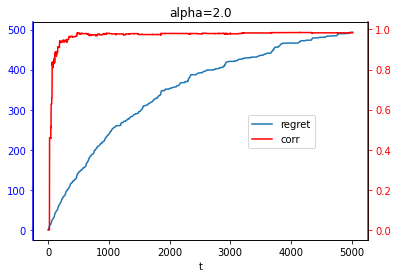

In [16]:
random.seed(42.0)  # int(time.time())
bandit = Bandit(20)
agent = UCB1(bandit, alpha=2.0)
agent.add_listener('regret', update_regret)
agent.add_listener('corr', update_rank_corr)
agent.run(5000)
plot_stats('alpha=2.0')

In [17]:
!pip3 install matplotlib

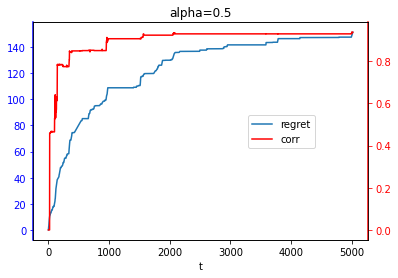

In [18]:
random.seed(42.0)  # int(time.time())
bandit = Bandit(20)
agent = UCB1(bandit, alpha=0.5)
agent.add_listener('regret', update_regret)
agent.add_listener('corr', update_rank_corr)
agent.run(5000)
plot_stats('alpha=0.5')